## Import av nødvendige moduler

In [1]:
import sys
src_path = '..\\src'
if src_path not in sys.path:
    sys.path.insert(0, src_path)

src_path_2 = '..\\venv\\Lib\\site-packages'
if src_path_2 not in sys.path:
    sys.path.insert(0, src_path_2)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error

import functions as fc

### Hente inn og forberede data
Henter inn nedbørsdata fra relevante kolonner i en csv-fil, sjekker for manglende data samt endrer tidsreferansen til datetime-format. Sjekker hva høyeste og laveste verdi for nedbørsmendge i datasettet er.


Datasett over nedbørsmengde
   verdi tidsforskyvning              referansetid
0   10.4           PT18H  2024-01-01T00:00:00.000Z
1    6.3            PT6H  2024-01-01T00:00:00.000Z
2    3.1           PT18H  2024-01-02T00:00:00.000Z
3    6.4            PT6H  2024-01-02T00:00:00.000Z
4    1.2           PT18H  2024-01-03T00:00:00.000Z 

referansetid er gjort om til DateTime
   verdi tidsforskyvning              referansetid
0   10.4           PT18H 2024-01-01 00:00:00+00:00
1    6.3            PT6H 2024-01-01 00:00:00+00:00
2    3.1           PT18H 2024-01-02 00:00:00+00:00
3    6.4            PT6H 2024-01-02 00:00:00+00:00
4    1.2           PT18H 2024-01-03 00:00:00+00:00 

verdi              0
tidsforskyvning    0
referansetid       0
dtype: int64
Empty DataFrame
Columns: [verdi, tidsforskyvning, referansetid]
Index: []


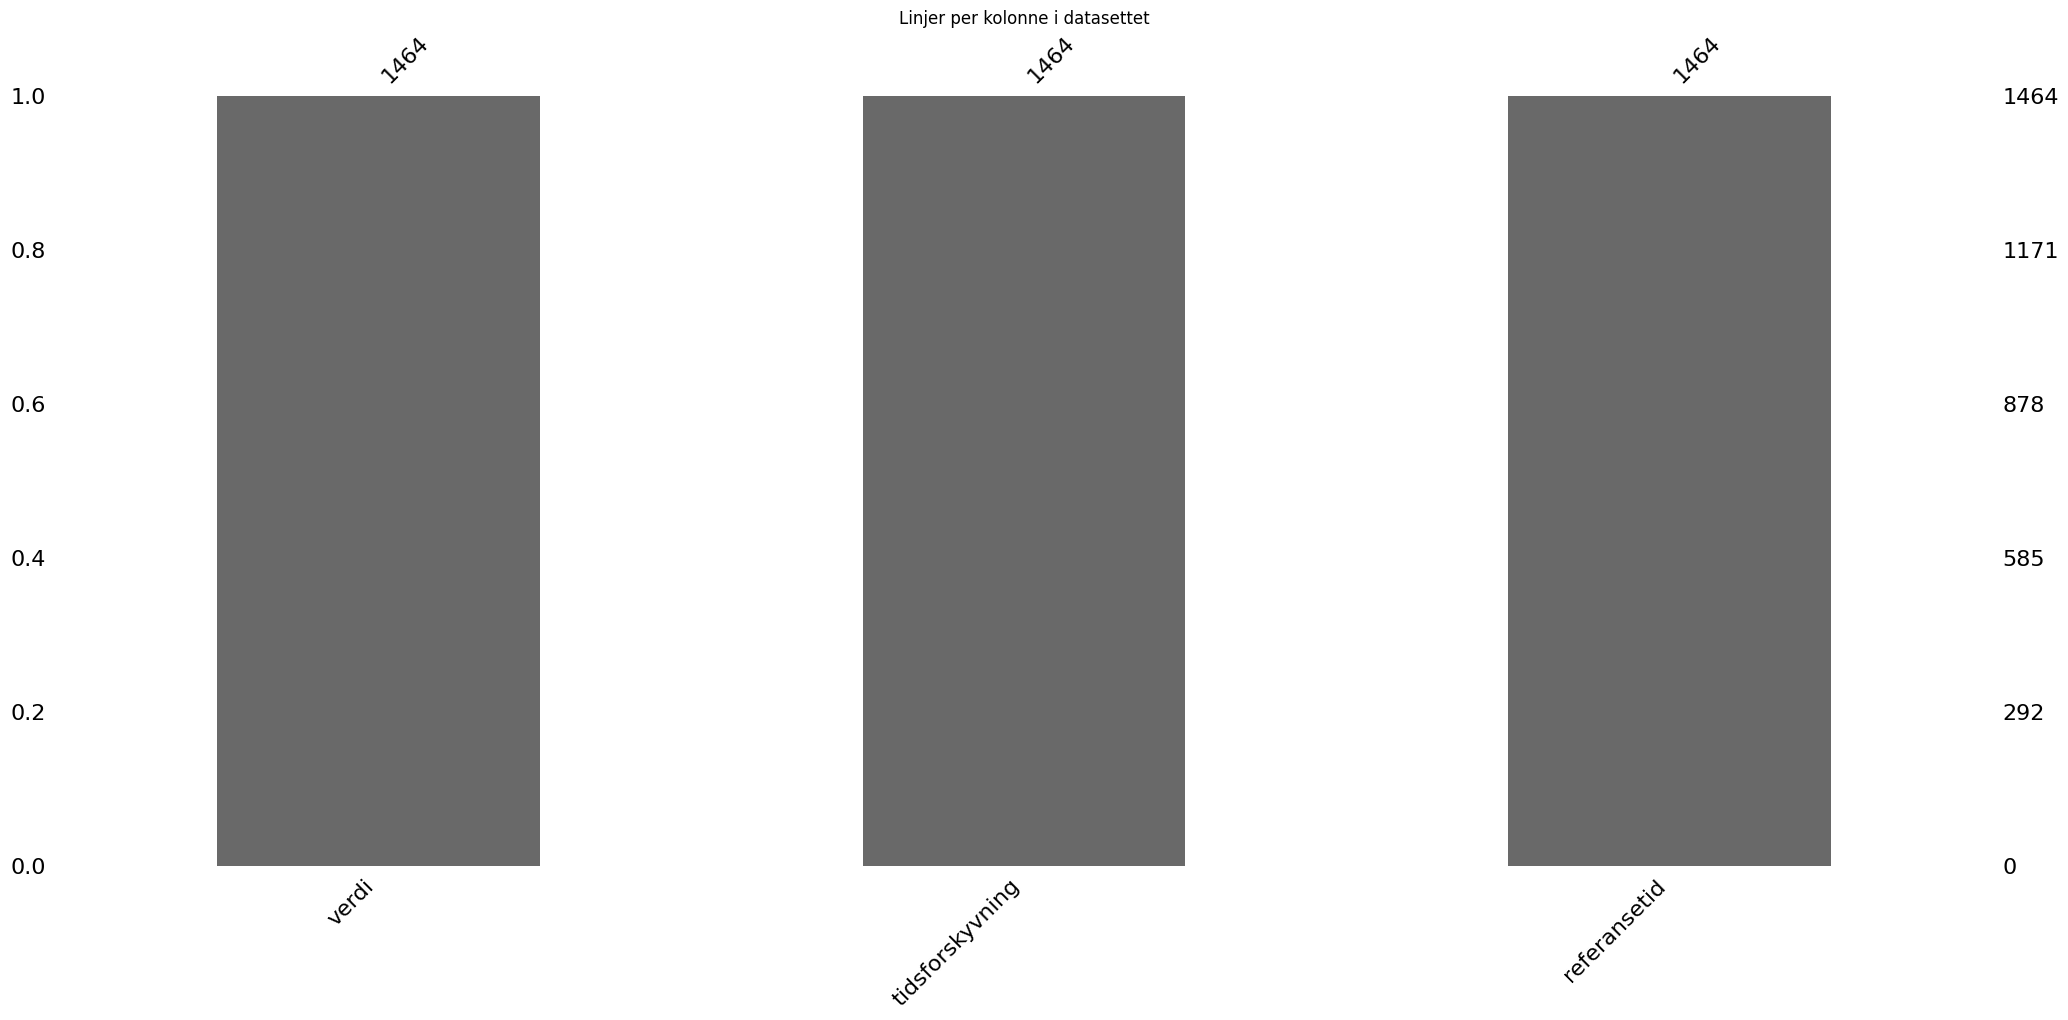

Den minste verdien er: 0.0
Den høyeste verdien er: 47.0


In [2]:
# Hente inn datasett fra data
try: 
    precipitation = pd.read_csv('../data/precipitation.csv')
except FileNotFoundError:
    print('Fila finnes ikke')
    
print('Datasett over nedbørsmengde')
print(precipitation.head(), '\n')

# Endre tidshenvisning til datetime-format
date = fc.make_datetime(precipitation)
print(precipitation.head(), '\n')

# Sjekker hvor mange av verdiene som mangler
fc.missing_numbers(precipitation)
plt.title('Linjer per kolonne i datasettet')
plt.show()

# Printer hva den høyeste og laveste verdien er 
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())

### Analysere datatyper
For å undersøke hvilke datatyper vi har med å gjøre, brukes den innebygde funksjonen info()på datasettet. 

Vi ser at data i kolonnen 'verdi' er av type float, som er forventet da dette er mengden nedbør representert i tallverdier. At verdiene allerede er i form av float, og ikke f.eks. string, gjør det mulig å regne på verdiene direkte, som er nyttig for videre analyse.

Datatypen til kolonnen tidsforskyvning tolkes som 'object', som vil si at funksjonen ikke kjenner igjen datatypen, og setter den til noe mer generisk. Dette er ikke få farlig, for vi skal uansett ikke bruke denne til noe annet enn å representere to ulike tidspunkt i løpet av et døg. Det er mulig å gjøre selv med en generisk datatype.

Vi ser at referansetiden er blitt korrekt satt til datetime-datatypen. Det tyder på at prosessen over har fungert som tenkt.

Vi ser også at det har blitt lagt til en ny kolonne der månedene er representert med et heltall, som er nyttig for den videre analysen, og viser at koden overfor fungerte som tenkt.

In [3]:
precipitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   verdi            1464 non-null   float64            
 1   tidsforskyvning  1464 non-null   object             
 2   referansetid     1464 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 34.4+ KB


### Introdusere feil i datasettet
Fordi datasettet i utgangspunktet ikke inneholdt noen manglende eller ekstreme verdier, har vi valgt å introdusere disse så vi har mer å jobbe med siden. Vi har valgt å lagre de tilfeldig utvalgte linjene som endres i en seed, så vi har kontroll på hvilke linjer som blir byttet ut når vi kjører koden på nytt. Dette gjør det lettere å sammenligne resutlater fra andre endringer underveis.

In [4]:
# Lagrer de bestemte linjene i precipitation det går utover
np.random.seed(123)

# Velger 5 tilfeldige verdier ut i fra lengden på datasettet
numExtreme = 5
mod_indices = np.random.choice(len(precipitation), numExtreme, replace=False)

print(mod_indices)

# Velger så 5 verdier mellom 15 og 19 
extreme_value = np.random.randint(15, 20, len(mod_indices))
print(extreme_value)

# Ganger de valgte verdiene i precipitation med extreme_values
precipitation.loc[mod_indices, 'verdi'] *= extreme_value

# Printer hva den høyeste og laveste verdien er
# Printer hva den høyeste og laveste verdien er 
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())


[  42   76 1375  252 1235]
[16 16 16 19 17]
Den minste verdien er: 0.0
Den høyeste verdien er: 134.4


### Visualisere resultater fra datasett med feil
Å regne ut gjennomsnitt og median gir et bilde på hvordan verdiene i datasettet fordeler seg. Hvis det er stor forskjell i de to kan det tyde på at settet har noen ekstreme verdier som trekker gjennomsnittet i en bestemt retning. Selv om forskjellen gjennomsnitt-median ikke er stor, kan det likevel finnes ekstreme verdier i datasettet. Visualisering av data i grafisk form gjør det lettere å oppdage disse eventuelle ekstreme verdiene, og se hvor ekstreme de er i forhold til resten av verdiene.

Gjennomsnittlig verdi for datasettet er 3.53
Medianen er 0.3


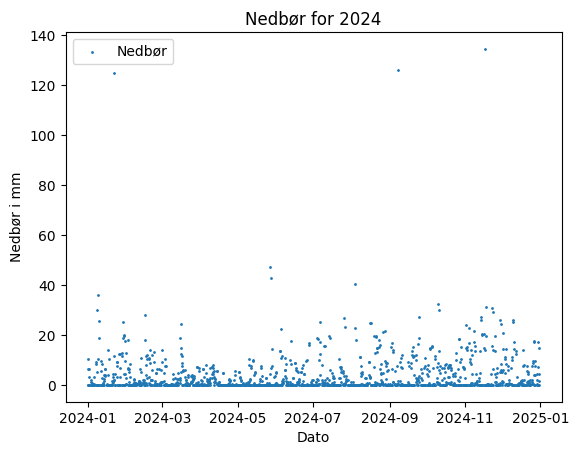

In [5]:
# Regne ut gjennomsnittlig nedbør over tid
fc.average_year(precipitation)
monthly_prcp = fc.average_other(precipitation, column='måned')

# Regne ut median
fc.median(precipitation)

# Visualiserer datasettet med extreme verdier
plt.scatter(date, precipitation['verdi'], label='Nedbør', s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør i mm') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()

### Skille ut ektreme verdier
Vi ønsker å fjerne de mest ekstreme verdiene fra datasettet, og setter derfor en grense for hvilke verdier vi antar at er relevante ut i fra en gitt avstand fra gjennomsnittsverdien og standardavviket. Ved å se på listen som dannes, er det tydelig at de ekstreme verdiene er spredt utover i datasettet. 

Gjennomsnittlig verdi for datasettet er 3.53
Standardavviket er 8.14
      verdi tidsforskyvning              referansetid  måned
42    124.8           PT18H 2024-01-22 00:00:00+00:00      1
92     28.0           PT18H 2024-02-16 00:00:00+00:00      2
294    47.0           PT18H 2024-05-27 00:00:00+00:00      5
297    42.7            PT6H 2024-05-28 00:00:00+00:00      5
432    40.5           PT18H 2024-08-04 00:00:00+00:00      8
566    32.3           PT18H 2024-10-10 00:00:00+00:00     10
569    29.8            PT6H 2024-10-11 00:00:00+00:00     10
746    30.1           PT18H 2024-01-08 00:00:00+00:00      1
749    35.8            PT6H 2024-01-09 00:00:00+00:00      1
1235  125.8            PT6H 2024-09-08 00:00:00+00:00      9
1375  134.4            PT6H 2024-11-17 00:00:00+00:00     11
1377   31.3            PT6H 2024-11-18 00:00:00+00:00     11
1386   30.8           PT18H 2024-11-23 00:00:00+00:00     11
1389   29.2            PT6H 2024-11-24 00:00:00+00:00     11


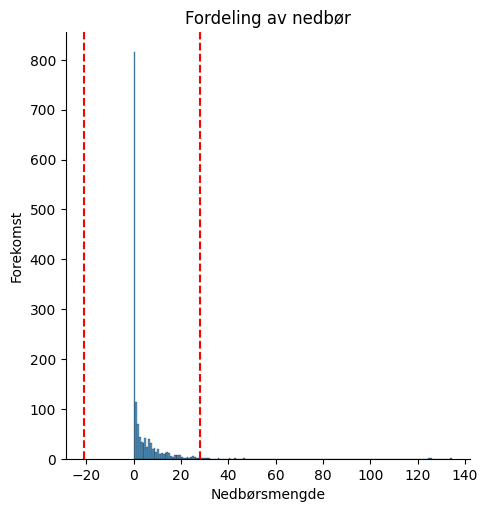

In [6]:
# Finner øvre og nedre grense
lower_limit, upper_limit = fc.lower_upper_limit(precipitation)

# Sier at de verdiene som er utenfor grensene lagres i outliers
outliers = precipitation[precipitation['verdi'].between(lower_limit, upper_limit) == False]
print(outliers) 

# Visualiserer datasettet med øvre og nedre grense 
plot = sns.displot(data=precipitation['verdi']).set(title='Fordeling av nedbør', xlabel='Nedbørsmengde', ylabel='Forekomst')
for ax in plot.axes.flat:
    ax.axvline(lower_limit, color='r', linestyle='--', label='Lower Limit')
    ax.axvline(upper_limit, color='r', linestyle='--', label='Upper Limit')


### Fjerne ekstreme verdier
Vi ser at det er flere verdier i datasettet som er usannsynlig høye i forhold til standardavviket, og ønsker derfor å fjerne de rfa settet før vi bruker det i videre analyse. Verdiene som ble skilt ut over fjernes derfor fra datasettet og erstattes med "nan", not a number, for å gjøre det lettere å forholde seg til videre.

Noe som er verdt å merke seg er at den nye høyeste verdien i datasettet nå er mye lavere enn det var i det opprinnelige datasettet som ble hentet ut fra Meterologisk institutt. Det vil si at vi ikke bare har fjernet de høye verdiene som ble kunstig tilført til datasettet manuelt, men også faktiske datapunkter som eksisterte i det opprinnelige settet.

[124.8, 28.0, 47.0, 42.7, 40.5, 32.3, 29.8, 30.1, 35.8, 125.80000000000001, 134.4, 31.3, 30.8, 29.2]
Den minste verdien er: 0.0
Den høyeste verdien er: 27.2


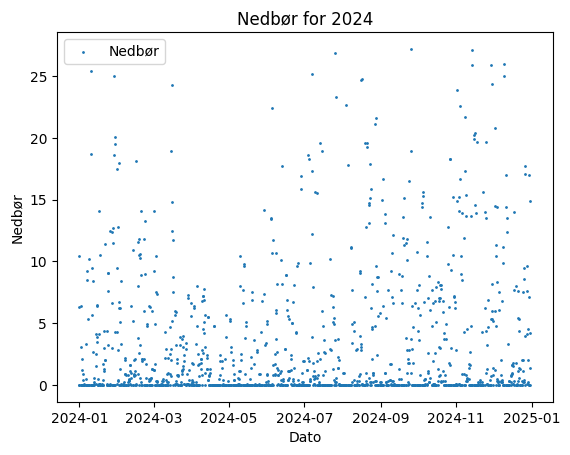

In [7]:
# Alle verdiene som er utenfor standardavviket legges i lista remove
remove = []
for i in outliers['verdi']:
    remove.append(i)
print(remove)

# Verdiene i precipitation som er lik verdiene i remove byttes ut med NaN
precipitation['verdi'] = precipitation['verdi'].replace(remove, np.nan)

# print den laveste og høyeste verdien for å vise at verdiene har endret seg
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())

# Visualiserer datasettet uten ekstreme verdier
plt.scatter(date, precipitation['verdi'], label='Nedbør', s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()


### Få oversikt over manglende verdier i datasettet
Etter å ha fjernet ekstreme verdier fra datasettet, vil man stå igjen med flere tomme celler. Vi ønsker å få ovresikt over hvor de befinner seg og hvor mange de er, så det er lettere å avgjøre hvordan man skal behandle de manglende dataene videre.

verdi              14
tidsforskyvning     0
referansetid        0
måned               0
dtype: int64
      verdi tidsforskyvning              referansetid  måned
42      NaN           PT18H 2024-01-22 00:00:00+00:00      1
92      NaN           PT18H 2024-02-16 00:00:00+00:00      2
294     NaN           PT18H 2024-05-27 00:00:00+00:00      5
297     NaN            PT6H 2024-05-28 00:00:00+00:00      5
432     NaN           PT18H 2024-08-04 00:00:00+00:00      8
566     NaN           PT18H 2024-10-10 00:00:00+00:00     10
569     NaN            PT6H 2024-10-11 00:00:00+00:00     10
746     NaN           PT18H 2024-01-08 00:00:00+00:00      1
749     NaN            PT6H 2024-01-09 00:00:00+00:00      1
1235    NaN            PT6H 2024-09-08 00:00:00+00:00      9
1375    NaN            PT6H 2024-11-17 00:00:00+00:00     11
1377    NaN            PT6H 2024-11-18 00:00:00+00:00     11
1386    NaN           PT18H 2024-11-23 00:00:00+00:00     11
1389    NaN            PT6H 2024-11-24 00:00:

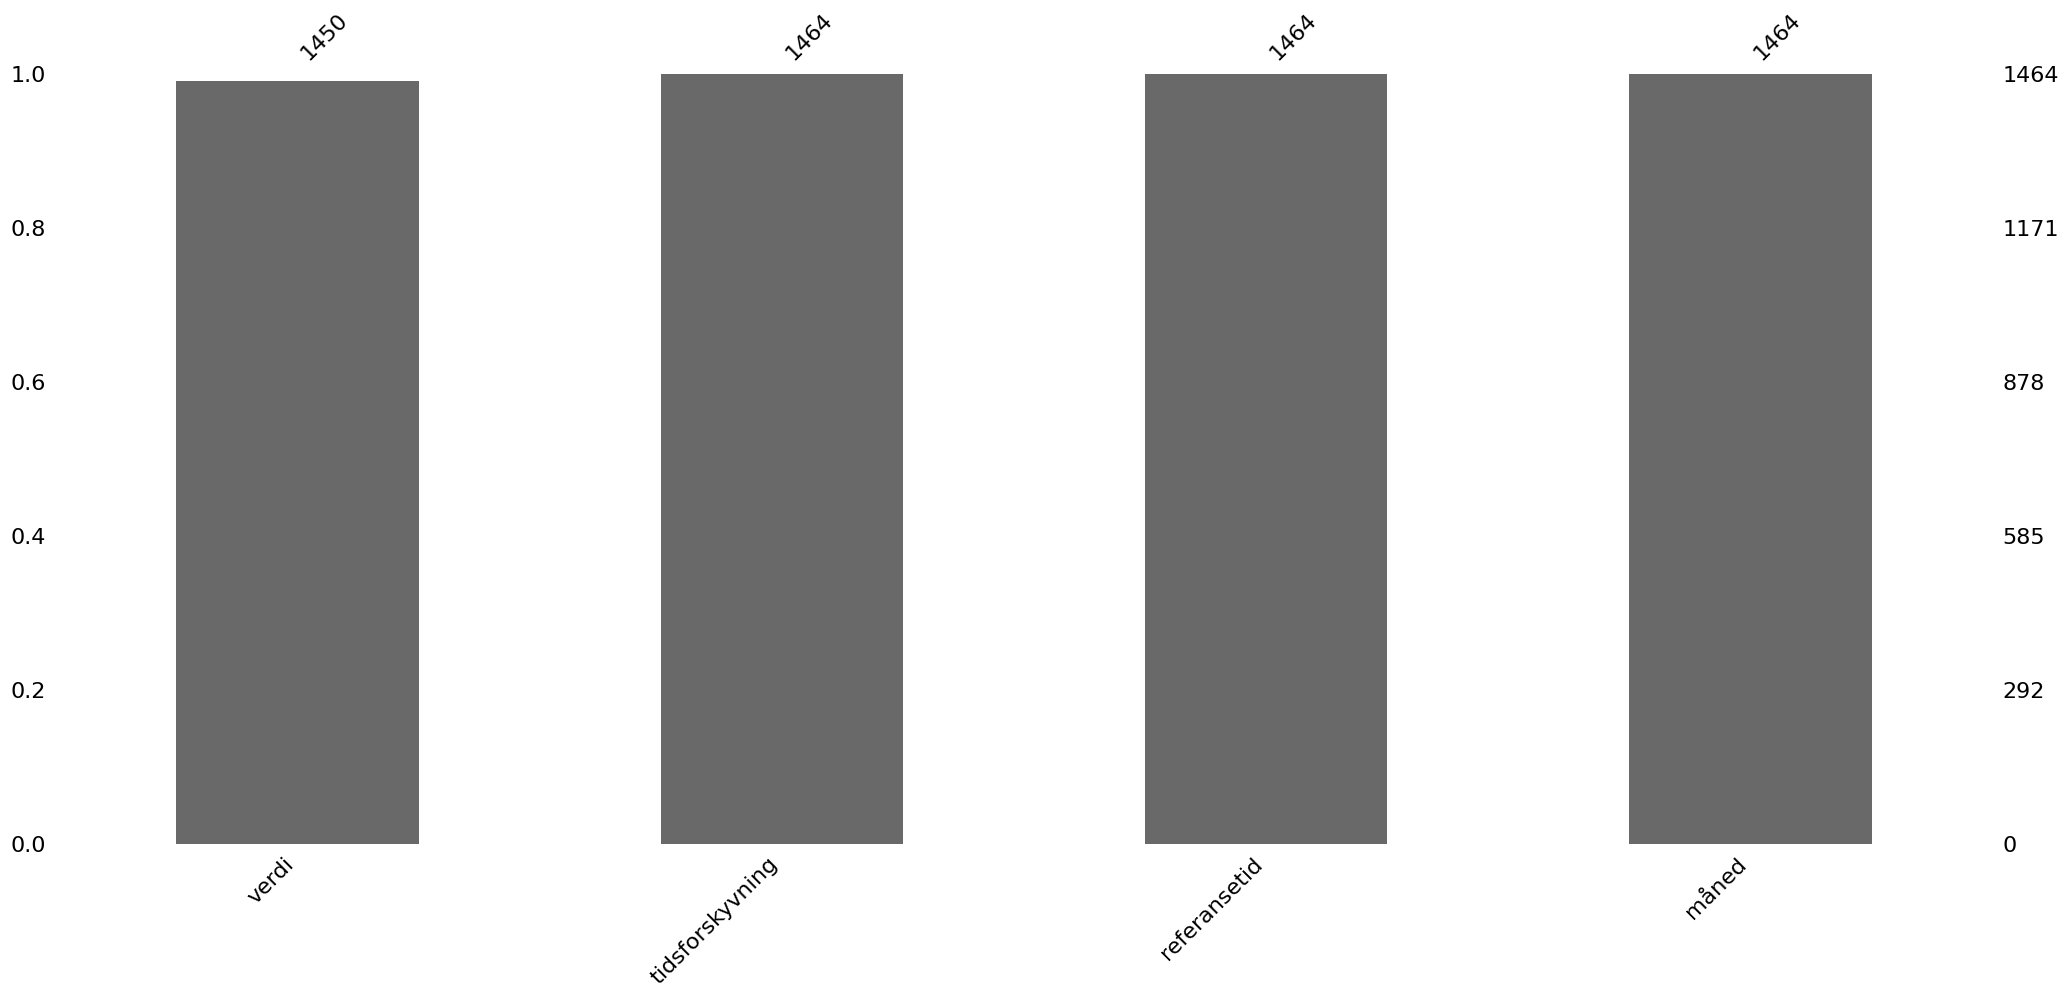

In [8]:
# Sjekker hvor mange og hvilke av verdiene som mangler
fc.missing_numbers(precipitation)

### Fylle inn manglende verdier i datasettet
Fyller inn de manglende verdiene i datasettet, regnet ut i fra omliggende verdier. Fordi de manglende verdiene er spredt utover i datasettet vil det ikke være urimelig å beregne verdiene ut i fra de som kommer rett før eller etter i settet.
Sjekker til slutt at alle verdiene er utfylt.

verdi              0
tidsforskyvning    0
referansetid       0
måned              0
dtype: int64


C:\Users\sofie\AppData\Local\Temp\ipykernel_27692\2721868208.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)
C:\Users\sofie\AppData\Local\Temp\ipykernel_27692\2721868208.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)


Empty DataFrame
Columns: [verdi, tidsforskyvning, referansetid, måned]
Index: []
referansetid er gjort om til DateTime


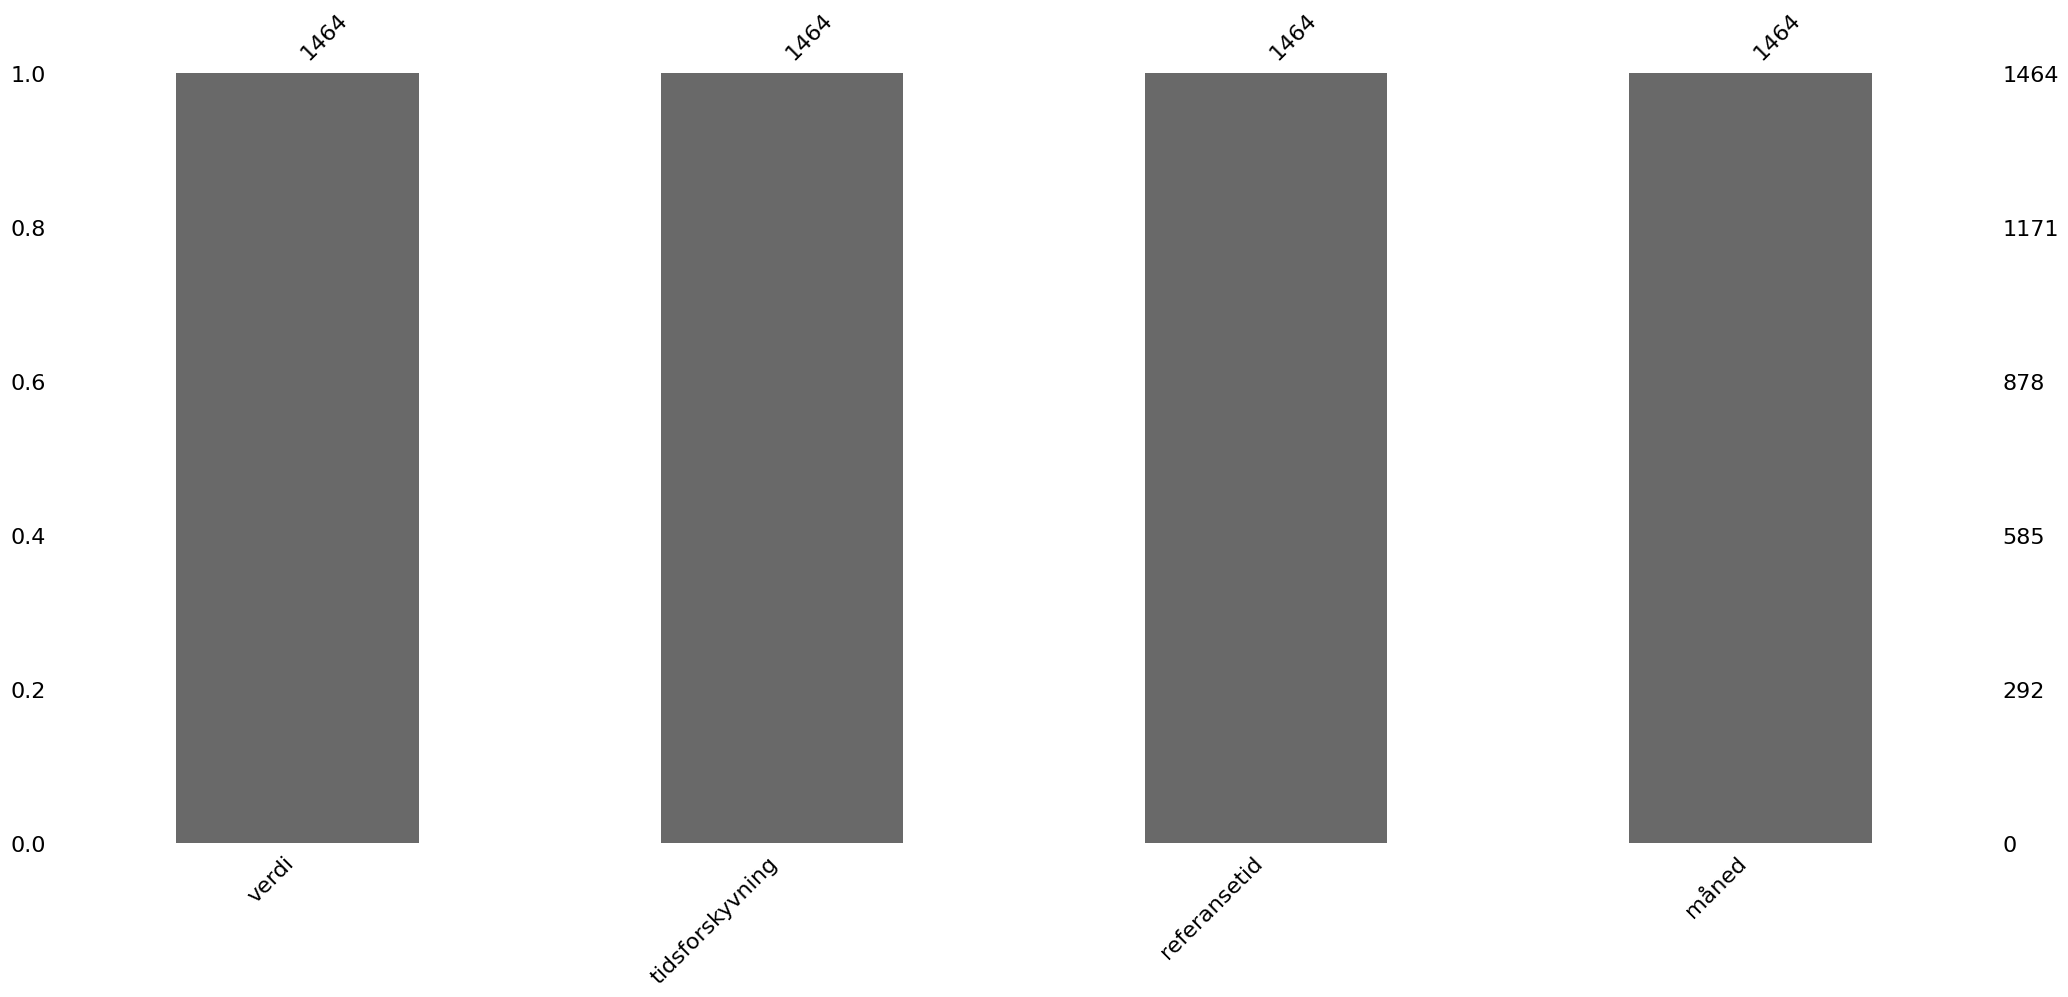

In [9]:
# Gjør NaN om til neste verdi i fila 
add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)

# Sjekker at verdiene er fylt inn
fc.missing_numbers(precipitation)

# Lagrer den endrede dataframen i en ny fil 
precipitation.to_csv('../data/clean_precipitation.csv', index=False)
# Lagrer det rensede og utfylte datasettet i en ny fil til videre bruk
try: 
    clean_prcp = pd.read_csv('../data/clean_precipitation.csv')
except FileNotFoundError:
    print('Fila finnes ikke')

# Konverterer dato til rett format
date = fc.make_datetime(clean_prcp)

### Undersøke det nye datasettet
Regner ut gjennomsnitt og median i det rensede datasettet, samt sjekker hvor mange dager det ikke har vært noe nedbør i løpet av året.

In [10]:
# Regner ut gjennomsnittet for hver måned
print('Gjennomsnittlig verdi per måned:')
monthly_average = fc.average_other(clean_prcp)
print(monthly_average)
print('\n')

# Regner ut gjennomsnitt for hele året
yearly_average = fc.average_year(clean_prcp)
print('\n')

# Regner ut medianen for året
yearly_median = fc.median(clean_prcp)
print('\n')

# Antall dager i året uten nedbør
no_prcp = [x for x in clean_prcp['verdi'] if x==0]
dry_days = (len(no_prcp)/2) # Deler lengden på lista i to, siden det er to verdier per dag
print(f'Antallet dager uten nedbør er {dry_days}') 
print(f'Antallet dager med nedbør er {365-dry_days}')

Gjennomsnittlig verdi per måned:
måned
1     3.67
2     2.74
3     2.29
4     1.39
5     1.41
6     2.69
7     2.80
8     3.85
9     3.15
10    3.52
11    5.45
12    3.80
Name: verdi, dtype: float64


Gjennomsnittlig verdi for datasettet er 3.06


Medianen er 0.3


Antallet dager uten nedbør er 298.0
Antallet dager med nedbør er 67.0


### Visualiserer det nye datasettet
Tegner opp en graf som visualiserer det nye datasettet, samt sammenligner gjennomsnitt og median.

Vi ser at det er betydelig forskjell i verdiene på medianen og gjennomsnittet, som kan forklares av den store mengden datapunkter med verdien 0 i datasettet. Selv om det finnes mange dater med høy nedbør som trekker gjennomsnittet opp, vil ikke disse påvirke medianen i like stor grad da antallet dager uten nedbør er mange flere.

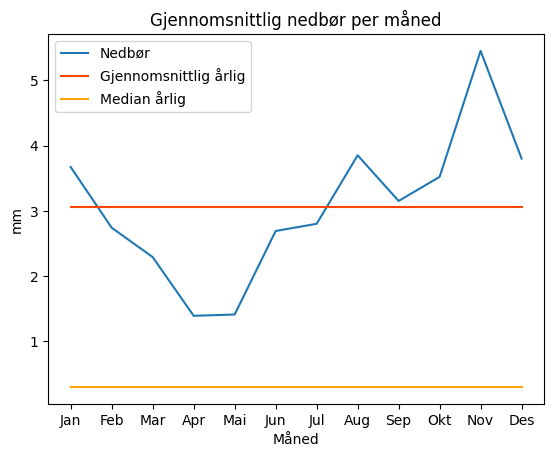

In [11]:
# Visualiserer gjennomsnittlig temperatur for hver måned
months = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des'] 

plt.plot(months, monthly_average, label='Nedbør')
plt.plot(months, yearly_average*np.ones(len(months)), color = 'orangered', label = 'Gjennomsnittlig årlig')
plt.plot(months, yearly_median*np.ones(len(months)), color = 'orange', label = 'Median årlig')
plt.xlabel('Måned')
plt.ylabel('mm')
plt.title('Gjennomsnittlig nedbør per måned')
plt.legend()
plt.show()

### Utforske betydningen av tidsforskyvning
Datasettet inneholder data fra to forskjellige tidspunkt i døgnet. Ved å sortere data ut i fra tidspunktet de er registrert, får vi sjekket om tidspunktet har noen nevneverdig betydning på verdiene i datasettet før vi bruker datasettet til å kjøre en prediktiv analyse. Vi ser her at gjennomsnittet for de to tidspunktene ikke har en batydelig forskjell.

In [12]:
# Visualiserer de ulike tidsforskyvningene
fig = px.scatter(clean_prcp, 
                x= 'referansetid', 
                y= 'verdi',
                color= 'tidsforskyvning', 
                trendline= 'ols',
                )

fig.update_layout(title=dict(text='Precipitation')
)
fig.show()

# Finner gjennomsnittet for hver av tidsforskyvningene
gj_måned = fc.average_other(clean_prcp, column='tidsforskyvning')
print(gj_måned)

tidsforskyvning
PT18H    3.00
PT6H     3.12
Name: verdi, dtype: float64


### Lineær regresjon
Datasettet deles inn i et treningssett og et testsett for en predikativ modell. Treningssettet mates først inn i en lineær regresjonsmodell, før testsettet brukes for å se om modellen fungerer som tenkt.


referansetid har fått labels
      verdi tidsforskyvning  referansetid  måned
0      10.4           PT18H             0      1
1       6.3            PT6H             0      1
2       3.1           PT18H             1      1
3       6.4            PT6H             1      1
4       1.2           PT18H             2      1
...     ...             ...           ...    ...
1459    4.5            PT6H           363     12
1460   17.0           PT18H           364     12
1461    7.1            PT6H           364     12
1462    4.2           PT18H           365     12
1463   14.9            PT6H           365     12

[1464 rows x 4 columns]
Datasettet er delt inn i train og test
Størrelsen på test er 0.3
koeffisienter: 0.005473624101745168
konstantledd: 2.2809613694426076


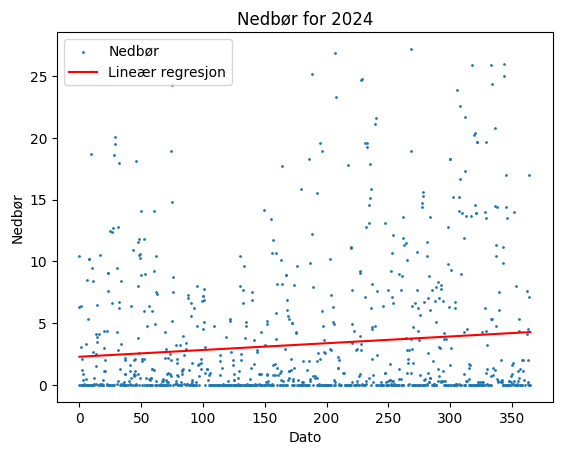

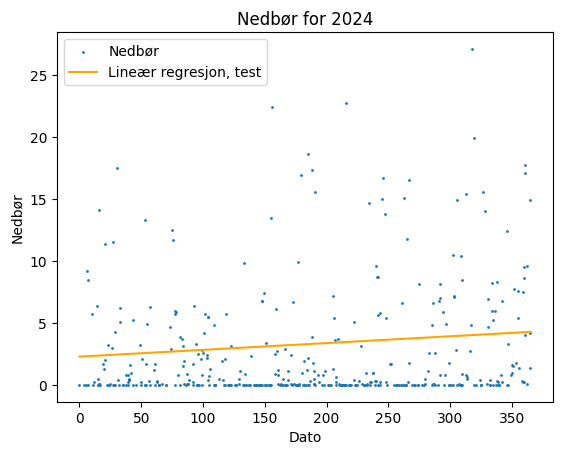

In [13]:
X_train, X_test, y_train, y_test = fc.train_test_set(clean_prcp, 0.3)

linear_pred = fc.linear(X_train, y_train)

plt.scatter(X_train, y_train, label='Nedbør', s=1)
plt.plot(X_train, linear_pred, label = 'Lineær regresjon', color = 'red')
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()

plt.scatter(X_test, y_test, label='Nedbør', s=1)
plt.plot(X_train, linear_pred, label = 'Lineær regresjon, test', color = 'orange')
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()

### Polynom regresjon
Rent visuelt kan det virke som om modellen ikke representerer dataene godt nok. I scatterplot-grafen kan man se en tydelig endring i nedbøren etter de første 50 dagene i året, før det kommer en oppgang igjen rundt dag 150. Dette gjenspeiles ikke tydelig visuelt i den lineære regresjonen. Det kan derfor være nyttig å teste ut en polynom regresjonsmodell, i dette tilfellet andregrads.

koeffisienter: -0.009083668098605455 4.0161730402949254e-05
konstantledd: 3.1417866642132344


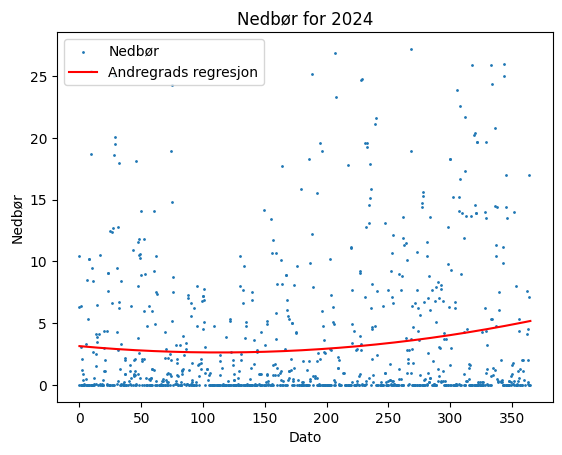

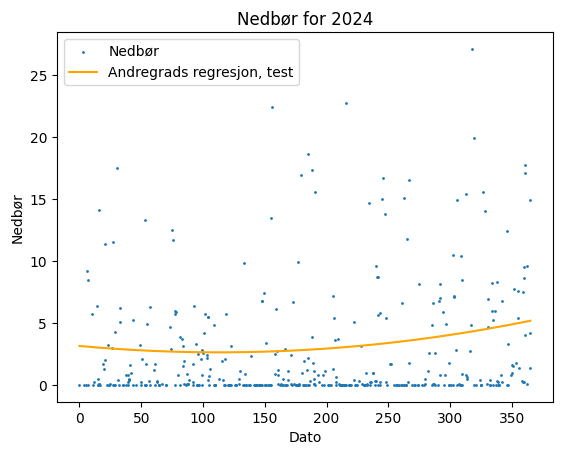

In [14]:
poly_pred = fc.poly(X_train, y_train)

plt.scatter(X_train, y_train, label='Nedbør', s=1)
plt.plot(X_train, poly_pred, label = 'Andregrads regresjon', color = 'red')
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()

plt.scatter(X_test, y_test, label='Nedbør', s=1)
plt.plot(X_train, poly_pred, label = 'Andregrads regresjon, test', color = 'orange')
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()

### Sammenligne regresjonsmodeller
Ut i fra den visuelle framstillingen kan det se ut som om andregradsfunksjonen bedre representerer dataene i datasettet. For å være sikker, kan man regne ut den gjennomsnittlige kvadratiske verdien av datasettet og sammenligne med verdiene i regrejonsmodellene. Lavere verdi vil tyde på en bedre tilsvaring mellom datasettet og modellen. 
I dette tilfellet kan vi se at det ikke er nevneverdig forskjell mellom de ulike løsningene, som kan tyde på at det ikek vil ha stor betydning hvilken modell man velger å bruke.

In [15]:
# Regner ut kvadratisk gjennomsnitt
print('Kvadratisk gjennomsnitt for den lineære regresjonen er:')
print(mean_squared_error(y_train, linear_pred))

print('Kvadratisk gjennomsnitt for andregradsregresjonen er:')
print(mean_squared_error(y_train, poly_pred))



Kvadratisk gjennomsnitt for den lineære regresjonen er:
29.643454232203414
Kvadratisk gjennomsnitt for andregradsregresjonen er:
29.483484726555485
